In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:
df = pd.read_csv("depr/train.csv")
df.head()

,id,title,body,label
0,0,Ok guys I have a dilemma for you,Ok so I’m thinking about asking out this girl ...,0.0
1,1,Update from my cringe overdramatic ass post,56 days ago from today I posted about my then-...,0.0
2,2,"Don't know if this is allowed, I work in youth...",NaN,0.0
3,3,So I think I just ascended to a newer level of...,So I was rebattling the elite four in Pokemon ...,0.0
4,4,My friend got a gf before me,But I have more reddit karma so I think I win 😎,0.0


In [3]:
df.isna().sum()

id          0
title       0
body     2074
label       0
dtype: int64

In [4]:
df['text'] = df['title'] + '. ' + df['body']

In [5]:
df.loc[df['body'].isna(),'text'] = df.loc[df['body'].isna(),'title']

In [6]:
df.isna().sum()

id          0
title       0
body     2074
label       0
text        0
dtype: int64

In [38]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from collections import Counter
import numpy as np
import pandas as pd

# 1. Dataset preparation
class RedditDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        tokens = self.tokenizer(text, self.max_length)
        return torch.tensor(tokens, dtype=torch.long), torch.tensor(label, dtype=torch.float32)

# Simple tokenizer using built vocabulary
class SimpleTokenizer:
    def __init__(self, vocab):
        self.vocab = vocab
        self.word_to_idx = {word: idx for idx, word in enumerate(vocab)}

    def tokenize(self, text):
        return [self.word_to_idx.get(word, self.word_to_idx["<UNK>"]) for word in text.split()]

    def __call__(self, text, max_length):
        tokens = self.tokenize(text)
        return tokens[:max_length] + [0] * (max_length - len(tokens))  # Pad or truncate

# 2. Vocabulary building
def build_vocab(texts, min_freq=2):
    word_counter = Counter()
    for text in texts:
        word_counter.update(text.split())
    vocab = ["<PAD>", "<UNK>"] + [word for word, count in word_counter.items() if count >= min_freq]
    return vocab

# 3. Model definition
import torch
import torch.nn as nn

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, num_layers, num_classes, max_length, ff_dim, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_length, embed_size))
        self.dropout = nn.Dropout(dropout)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Attention Pooling
        self.attention_weights = nn.Linear(embed_size, 1)
        self.softmax = nn.Softmax(dim=1)

        # Fully connected layer
        self.fc = nn.Sequential(
            nn.Linear(embed_size, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, num_classes)
        )

    def forward(self, x):
        # Embedding + Positional Encoding
        x = self.embedding(x) + self.positional_encoding[:, :x.size(1), :]
        x = self.dropout(x)

        # Transformer Encoder
        x = self.transformer(x)

        # Attention Pooling
        attention_scores = self.softmax(self.attention_weights(x))  # [batch_size, seq_len, 1]
        x = (attention_scores * x).sum(dim=1)  # Weighted sum -> [batch_size, embed_size]

        # Fully Connected Layer
        return self.fc(x)


# 4. Training loop
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs, device):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        model.eval()
        val_loss, val_acc = 0.0, 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for texts, labels in val_loader:
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()

                preds = torch.sigmoid(outputs).round()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        val_loss /= len(val_loader)
        val_acc = accuracy_score(all_labels, all_preds)
        val_auc = roc_auc_score(all_labels, all_preds)
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}")

def train_model_with_threshold(model, train_loader, val_loader, tokenizer, max_length, epochs, device, optimizer, criterion):
    model.to(device)
    best_threshold = 0.5  # Инициализация порога (по умолчанию 0.5)
    best_f1 = 0  # Лучший F1-score

    for epoch in range(epochs):
        # ======== ОБУЧЕНИЕ ========
        model.train()
        for batch in train_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

        # ======== ОЦЕНКА НА ВАЛИДАЦИИ ========
        model.eval()
        val_labels = []
        val_probs = []
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                inputs = inputs.to(device)
                outputs = model(inputs)
                probs = torch.sigmoid(outputs).squeeze().cpu().numpy()
                val_labels.extend(labels.numpy())
                val_probs.extend(probs)

        # Выбор оптимального порога
        thresholds = precision_recall_curve(val_labels, val_probs)[2]  # Пороги
        f1_scores = [f1_score(val_labels, (val_probs >= t).astype(int)) for t in thresholds]
        epoch_best_threshold = thresholds[f1_scores.index(max(f1_scores))]
        epoch_best_f1 = max(f1_scores)

        # Сохраняем лучший порог, если текущий лучше
        if epoch_best_f1 > best_f1:
            best_f1 = epoch_best_f1
            best_threshold = epoch_best_threshold

        print(f"Epoch {epoch + 1}/{epochs} | Loss: {loss.item():.4f} | Best F1: {best_f1:.4f} at threshold {best_threshold:.4f}")

    return model, best_threshold

In [39]:
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score

def find_best_threshold(y_true, y_probs):
    # ROC-кривая
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_probs)

    # Precision-Recall кривая
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_probs)

    # F1-скоры для каждого порога
    f1_scores = [f1_score(y_true, (y_probs >= thresh).astype(int)) for thresh in thresholds_pr]

    # Находим лучший порог по F1-score
    best_threshold = thresholds_pr[f1_scores.index(max(f1_scores))]
    best_f1 = max(f1_scores)

    print(f"Лучший порог: {best_threshold:.4f}, F1-score: {best_f1:.4f}")
    return best_threshold


In [40]:
from tokenizers import Tokenizer, models, trainers, processors
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import Lowercase
from tokenizers.decoders import WordPiece

# 1. Создание BPE токенайзера
class BPETokenizer:
    def __init__(self, vocab_size=5000):
        self.tokenizer = Tokenizer(models.BPE())
        self.tokenizer.pre_tokenizer = Whitespace()
        self.tokenizer.normalizer = Lowercase()
        self.tokenizer.decoder = WordPiece()
        self.vocab_size = vocab_size

    def train(self, texts):
        trainer = trainers.BpeTrainer(vocab_size=self.vocab_size, special_tokens=["<PAD>", "<UNK>"])
        self.tokenizer.train_from_iterator(texts, trainer)

    def tokenize(self, text):
        return self.tokenizer.encode(text).ids

    def __call__(self, text, max_length):
        tokens = self.tokenize(text)
        return tokens[:max_length] + [0] * (max_length - len(tokens))  # Pad or truncate

# 2. Обучение BPE токенайзера
def build_bpe_tokenizer(texts, vocab_size=5000):
    tokenizer = BPETokenizer(vocab_size=vocab_size)
    tokenizer.train(texts)
    return tokenizer

In [41]:
# # Build vocab from df['text']
# vocab = build_vocab(df['text'], min_freq=1)
# print(f"Vocabulary size: {len(vocab)}")

# Hyperparameters
max_length = 50
embed_size = 128
num_heads = 4
num_layers = 8
ff_dim = 256
num_classes = 1
vocab_size = 5000
batch_size = 4
epochs = 10
lr = 1e-4

# Tokenizer
tokenizer = build_bpe_tokenizer(df['text'].tolist(), vocab_size=vocab_size)

# Dataset and DataLoader
texts, labels = df['text'].tolist(), df['label'].tolist()
dataset = RedditDataset(texts, labels, tokenizer, max_length)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Model, optimizer, loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerClassifier(vocab_size, embed_size, num_heads, num_layers, num_classes, max_length, ff_dim=ff_dim)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()

# Train the model
# train_model(model, train_loader, val_loader, optimizer, criterion, epochs, device)
trained_model, best_threshold = train_model_with_threshold(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    tokenizer=tokenizer,
    max_length=max_length,
    epochs=15,
    device=device,
    optimizer=optimizer,
    criterion=criterion
)

C:\Users\user\PycharmProjects\spbu_deep_learning1\.venv\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/15 | Loss: 0.4353 | Best F1: 0.5245 at threshold 0.4443
Epoch 2/15 | Loss: 0.0587 | Best F1: 0.5551 at threshold 0.3812
Epoch 3/15 | Loss: 0.0863 | Best F1: 0.5723 at threshold 0.2145
Epoch 4/15 | Loss: 0.3728 | Best F1: 0.5882 at threshold 0.3466
Epoch 5/15 | Loss: 0.1510 | Best F1: 0.5882 at threshold 0.3466
Epoch 6/15 | Loss: 0.1438 | Best F1: 0.6109 at threshold 0.2463
Epoch 7/15 | Loss: 0.0610 | Best F1: 0.6109 at threshold 0.2463
Epoch 8/15 | Loss: 0.2977 | Best F1: 0.6109 at threshold 0.2463
Epoch 9/15 | Loss: 0.1156 | Best F1: 0.6149 at threshold 0.2256
Epoch 10/15 | Loss: 0.0425 | Best F1: 0.6311 at threshold 0.4222
Epoch 11/15 | Loss: 0.0242 | Best F1: 0.6311 at threshold 0.4222
Epoch 12/15 | Loss: 0.2553 | Best F1: 0.6311 at threshold 0.4222
Epoch 13/15 | Loss: 0.2108 | Best F1: 0.6311 at threshold 0.4222
Epoch 14/15 | Loss: 0.1172 | Best F1: 0.6530 at threshold 0.3003
Epoch 15/15 | Loss: 0.6056 | Best F1: 0.6599 at threshold 0.3773


In [46]:
trained_model, best_threshold = train_model_with_threshold(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    tokenizer=tokenizer,
    max_length=max_length,
    epochs=15,
    device=device,
    optimizer=optimizer,
    criterion=criterion
)

Epoch 1/15 | Loss: 0.1478 | Best F1: 0.7551 at threshold 0.5955
Epoch 2/15 | Loss: 0.1019 | Best F1: 0.7551 at threshold 0.5955
Epoch 3/15 | Loss: 0.0755 | Best F1: 0.7618 at threshold 0.5402
Epoch 4/15 | Loss: 0.1003 | Best F1: 0.7680 at threshold 0.5858
Epoch 5/15 | Loss: 0.0032 | Best F1: 0.7680 at threshold 0.5858
Epoch 6/15 | Loss: 0.0048 | Best F1: 0.7680 at threshold 0.5858
Epoch 7/15 | Loss: 0.0051 | Best F1: 0.7680 at threshold 0.5858
Epoch 8/15 | Loss: 0.5743 | Best F1: 0.7680 at threshold 0.5858
Epoch 9/15 | Loss: 0.9573 | Best F1: 0.7680 at threshold 0.5858
Epoch 10/15 | Loss: 0.0291 | Best F1: 0.7680 at threshold 0.5858
Epoch 11/15 | Loss: 0.5175 | Best F1: 0.7680 at threshold 0.5858
Epoch 12/15 | Loss: 0.0369 | Best F1: 0.7680 at threshold 0.5858
Epoch 13/15 | Loss: 0.0950 | Best F1: 0.7680 at threshold 0.5858
Epoch 14/15 | Loss: 0.1882 | Best F1: 0.7680 at threshold 0.5858
Epoch 15/15 | Loss: 0.1469 | Best F1: 0.7680 at threshold 0.5858


In [47]:
# Предсказание на тестовом наборе данных
def predict_on_test(model, test_texts, tokenizer, max_length, device):
    model.eval()
    model.to(device)

    # Токенизация текстов
    test_tokens = [tokenizer(text, max_length) for text in test_texts]
    test_dataset = torch.tensor(test_tokens, dtype=torch.long)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    predictions = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            outputs = model(batch)
            probs = torch.sigmoid(outputs).squeeze(dim=-1)  # Ensure it's a 1D array
            predictions.extend(probs.cpu().numpy().tolist())  # Convert to list and extend
    return predictions

# Загрузка тестового набора (замените путь на реальный)
test_df = pd.read_csv('./depr/test.csv')
test_df['text'] = test_df['title'] + '. ' + test_df['body']
test_df.loc[test_df['body'].isna(),'text'] = test_df.loc[test_df['body'].isna(),'title']

# Предсказания
test_predictions = predict_on_test(model, test_df['text'].tolist(), tokenizer, max_length, device)

# Добавление предсказаний в DataFrame
test_df['label'] = test_predictions
test_df['label'] = (np.array(test_predictions) >= best_threshold).astype(int)
# Сохранение результатов
test_df[['id', 'label']].to_csv("depr/test_predictions.csv", index=False)
print("Предсказания сохранены в test_predictions.csv")


Предсказания сохранены в test_predictions.csv


In [23]:
best_threshold = find_best_threshold(df['text'].tolist(), df['label'].tolist())

ValueError: multiclass format is not supported

<Axes: >

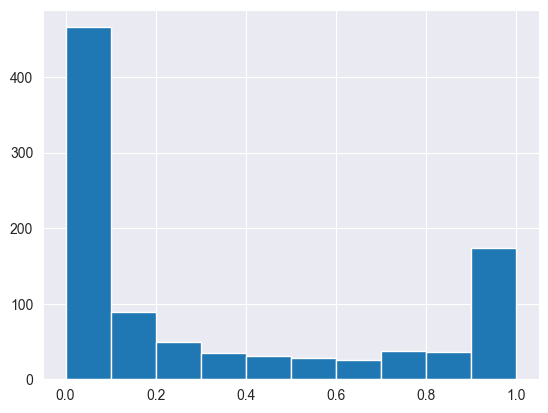

In [25]:
pd.Series(test_predictions).hist()

In [49]:
torch.save(model, "depr/model.pt")